# Research of the game success

The online store *Ice* sells videogames all over the world. User and expert reviews, genres, platforms (e.g. Xbox or PlayStation), and historical data on game sales are available from open sources. We need *to identify patterns that determine whether a game succeeds or not*. This allows us to put our money on a potentially hot new item and plan advertising campaigns.

### Step 1. Open the data file and study the general information

In [1]:
# import libs
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import math as m
from scipy import stats as st

*Read the file with data from "Ice" store and save it to the variable.*

In [2]:
# read the data
df_games = pd.read_csv('games.csv')

In [3]:
# df_games.to_csv('games.csv', index=False)

*Print the first 5 rows*

In [4]:
df_games.head()

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


*Data description:*
- Name
- Platform
- Year_of_Release
- Genre
- NA_sales (North American sales in USD million)
- EU_sales (sales in Europe in USD million)
- JP_sales (sales in Japan in USD million)
- Other_sales (sales in other countries in USD million)
- Critic_Score (maximum of 100)
- User_Score (maximum of 10)
- Rating (ESRB) - Entertainment Software Rating Board. The ESRB evaluates a game's content and assigns an appropriate age categories, such as Teen and Mature.

*Look at the general information of our dataset*

In [5]:
df_games.info() # use info() method

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
Name               16713 non-null object
Platform           16715 non-null object
Year_of_Release    16446 non-null float64
Genre              16713 non-null object
NA_sales           16715 non-null float64
EU_sales           16715 non-null float64
JP_sales           16715 non-null float64
Other_sales        16715 non-null float64
Critic_Score       8137 non-null float64
User_Score         10014 non-null object
Rating             9949 non-null object
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


*Calculate percentage of missing values*

In [6]:
def missing_vals_per(df):
    # select columns that contain NaN values
    df_missing_cols = df[df.columns[df.isnull().any()].tolist()]
    # count percentage of NaN values
    df_missing_vals = df_missing_cols.isna().mean().round(4) * 100
    return df_missing_vals

missing_vals_per(df_games)

Name                0.01
Year_of_Release     1.61
Genre               0.01
Critic_Score       51.32
User_Score         40.09
Rating             40.48
dtype: float64

*Use describe() method for more information*

Check the numeric values

In [7]:
df_games.describe()

,Year_of_Release,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score
count,16446.000000,16715.000000,16715.000000,16715.000000,16715.000000,8137.000000
mean,2006.484616,0.263377,0.145060,0.077617,0.047342,68.967679
std,5.877050,0.813604,0.503339,0.308853,0.186731,13.938165
min,1980.000000,0.000000,0.000000,0.000000,0.000000,13.000000
25%,2003.000000,0.000000,0.000000,0.000000,0.000000,60.000000
50%,2007.000000,0.080000,0.020000,0.000000,0.010000,71.000000
75%,2010.000000,0.240000,0.110000,0.040000,0.030000,79.000000
max,2016.000000,41.360000,28.960000,10.220000,10.570000,98.000000


Check the quantitative values

In [8]:
df_games.describe(include='object')

,Name,Platform,Genre,User_Score,Rating
count,16713,16715,16713,10014,9949
unique,11559,31,12,96,8
top,Need for Speed: Most Wanted,PS2,Action,tbd,E
freq,12,2161,3369,2424,3990


In [9]:
# count the "tbd" (to be determined)
df_games[df_games['User_Score'] == 'tbd']['User_Score'].count()

2424

### Conclusion

- We need to replace the column names (make them lowercase).
- We need to change object type for:
 - "Year_of_Release" to int.
 - "User_Score" to float and multiply to 10 for more convinience. We have 2424 "tbd" (to be determined) in the "User_Score". I think we need to replace with NaN values to process later.
- We have a lot NaN in "critic_score", "user_score", "rating".
- We have "0" sales as well. Probably we have sale, but when round to 0.00, the data were missed.

### Step 2. Data preprocessing

We should replace the columns names, process NaN values, change the data types, check the data for duplicates and drop them, calculate the total sales.

*Replace the columns names before we start*

In [10]:
# replace the columns names to lowercase
df_games.columns = map(str.lower, df_games.columns)

*Replace "tbd" with NaN values for easier handling*

In [11]:
 # use replace method
df_games['user_score'].replace('tbd', np.nan, inplace=True)
# check the values
df_games[df_games['user_score'] == 'tbd']['user_score'].count()

0

### Processing missing values

*Look at the quantity of NaN values in "df_games".*

In [12]:
def missing_vals(data):
    print('The number of NaN values in:')
    for column in data.columns:
        nan_vals = data[column].isnull().sum() # use isnull() method to count number of NaN values
        if nan_vals > 0:
            print('- {} ='.format(column), nan_vals)

missing_vals(df_games)

The number of NaN values in:
- name = 2
- year_of_release = 269
- genre = 2
- critic_score = 8578
- user_score = 9125
- rating = 6766


- "name", "genre": only 4 values total. Just drop it.
- "year_of_release", "critic_score", "user_score", "rating": do nothing, leave it as it is. Because we have a lot of missing values. If we replace them with something, then this may affect further analysis.

*Drop NaN in the "name" and "genre"*

In [13]:
df_games.dropna(subset= ['name','genre'], inplace = True)

### Data type replacement

Replace a type for:
- "year_of_release" to Int32.
- "user_score" to float with "to_numeric" method, because we have NaN values.

*Replace a type for "year_of_release" from float to Int32.*

In [14]:
df_games['year_of_release'] = df_games['year_of_release'].astype('Int32') # use astype() method

*Replace a type for "user_score" from object to float with "to_numeric" method.*

In [15]:
df_games['user_score'] = pd.to_numeric(df_games['user_score'], errors='ignore') # use to_numeric method

In [16]:
df_games['user_score'] = df_games['user_score'] * 10 # multiply to 10

### Processing duplicates

In [17]:
df_games.duplicated().sum() # summarizes duplicates

0

There's no duplicates.

### Calculate the total sales 

In [18]:
df_games['total_sales'] = df_games['na_sales'] + df_games['eu_sales'] + df_games['jp_sales'] + df_games['other_sales']

In [19]:
df_games.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006,Sports,41.36,28.96,3.77,8.45,76.0,80.0,E,82.54
1,Super Mario Bros.,NES,1985,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008,Racing,15.68,12.76,3.79,3.29,82.0,83.0,E,35.52
3,Wii Sports Resort,Wii,2009,Sports,15.61,10.93,3.28,2.95,80.0,80.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


### Conclusion

We've processed missing values, replaced types for all needed columns for convenience and clarity, added new columnn with total sales. Probably we have missing values, because some data were got from open sources.

### Categorizing Data

*Categorize the data by "platform" column.*

In [20]:
# look at the platforms types, count total number of games
df_games['platform'].value_counts()

PS2     2161
DS      2151
PS3     1331
Wii     1320
X360    1262
PSP     1209
PS      1197
PC       974
XB       824
GBA      822
GC       556
3DS      520
PSV      430
PS4      392
N64      319
XOne     247
SNES     239
SAT      173
WiiU     147
2600     133
NES       98
GB        98
DC        52
GEN       27
NG        12
SCD        6
WS         6
3DO        3
TG16       2
PCFX       1
GG         1
Name: platform, dtype: int64

*Categorize the platforms to 6 types*

In [21]:
# create the func categorize platforms
def platform_cat(platform):        
    if platform in ('PS','PS2', 'PS3', 'PS4', 'PSP'):
        return 'playstation'
    if platform in ('X360', 'XB', 'XOne'):
        return 'xbox'    
    if platform in ('NES', 'DS', 'SNES', '3DS', 'N64', 'GC', 'GB', 'GBA', 'Wii', 'WiiU'):
        return 'nintendo'
    if platform == 'PC':
        return 'pc'
    else:
        return 'other'
    
df_games['platform_family'] = df_games['platform'].apply(platform_cat) # use apply() method to process column
df_games['platform_family'].value_counts() # check the values    

playstation    6290
nintendo       6270
xbox           2333
pc              974
other           846
Name: platform_family, dtype: int64

*Categorize the data by "critic_score" and "user_score" column.*

In [22]:
# create the func categorize by score
def score_cat(score):        
    if score < 11:
        return '10'
    if score < 21:
        return '20'
    if score < 31:
        return '30'
    if score < 41:
        return '40'
    if score < 51:
        return '50'
    if score < 61:
        return '60'
    if score < 71:
        return '70'
    if score < 81:
        return '80'
    if score < 91:
        return '90'
    if score < 101:
        return '100'
    else:
        return np.nan  

*Create "critic_score_cat" column*

In [23]:
df_games['critic_score_cat'] = df_games['critic_score'].apply(score_cat) # use apply() method to process column
df_games['critic_score_cat'].value_counts() # check the values  

80     2344
70     1949
90     1518
60     1188
50      571
100     257
40      236
30       63
20       11
Name: critic_score_cat, dtype: int64

*Create "user_score_cat" column*

In [24]:
df_games['user_score_cat'] = df_games['user_score'].apply(score_cat) # use apply() method to process column
df_games['user_score_cat'].value_counts() # check the values   

80     2372
90     2114
70     1403
60      765
50      379
40      207
100     184
30      106
20       45
10       15
Name: user_score_cat, dtype: int64

### Conclusion

Playstation is the most popular family platform the whole time by the number of games.

### Step 3. Analyze the data

### How many games were released in different years?

In [25]:
df_games_num = (
    # group by year
    df_games.groupby('year_of_release')
    # rename columns and count number of games
    .agg(games_num=('year_of_release', 'count'))
)

# sort values in descending order and show 10 rows
df_games_num.sort_values(by='games_num', ascending=False).head(10)

,games_num
year_of_release,
2008,1427
2009,1426
2010,1255
2007,1197
2011,1136
2006,1006
2005,939
2002,829
2003,775


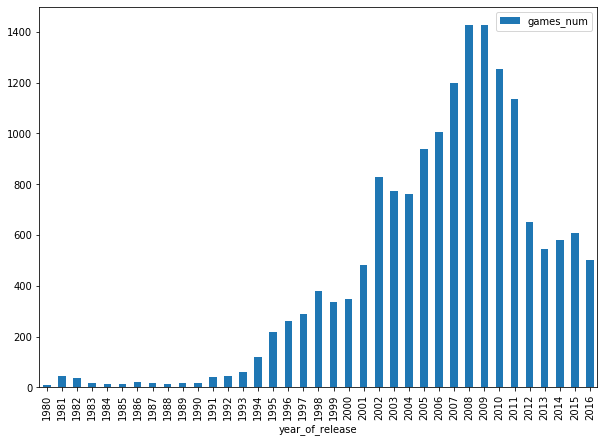

In [26]:
# plot the hist for "games_num"
df_games_num.plot(kind='bar', y='games_num', figsize=(10, 7))
plt.show()

### Conclusion

We see that the growth in the number of released games began after 1993. And the maximum values were achieved in 2008-2009, then there was a sharp decline. Probably mobile phones began to actively develop, the release of the game for consoles began to take longer due to the complexity of their production.

### Look at how sales varied from platform to platform

*Choose the platforms with the greatest total sales*

In [27]:
df_games_platform_sales = (
    # group by platform
    df_games.groupby('platform')
    # rename columns and calculate total sales for platforms
    .agg(platform_sales=('total_sales', 'sum'))
)

# sort values in descending order and show 10 rows
df_games_platform_sales_top_10 = df_games_platform_sales.sort_values(by='platform_sales', ascending=False).head(10)
df_games_platform_sales_top_10

,platform_sales
platform,
PS2,1255.77
X360,971.42
PS3,939.65
Wii,907.51
DS,806.12
PS,730.86
GBA,317.85
PS4,314.14
PSP,294.05


*Group 10 top platforms by year and build a distribution based on data for each year*


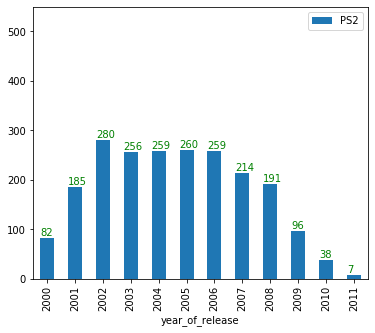

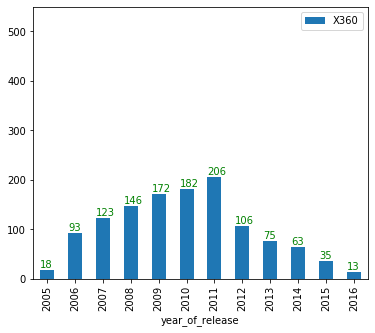

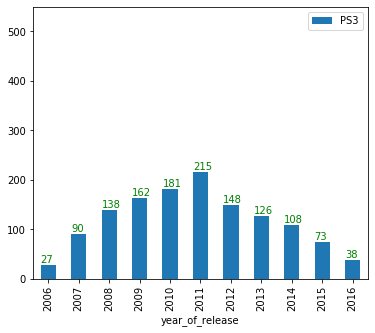

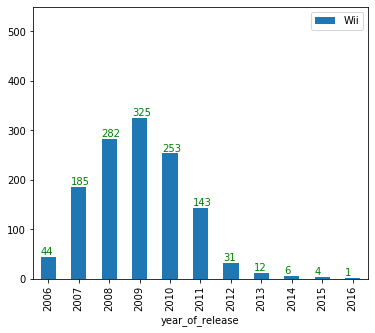

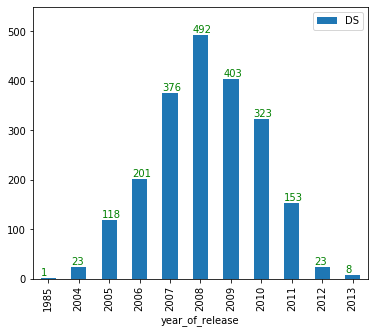

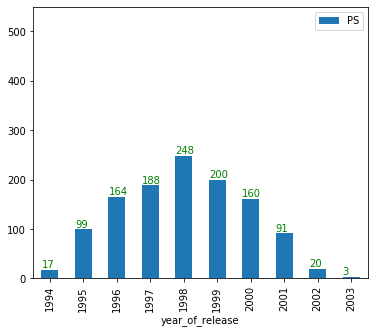

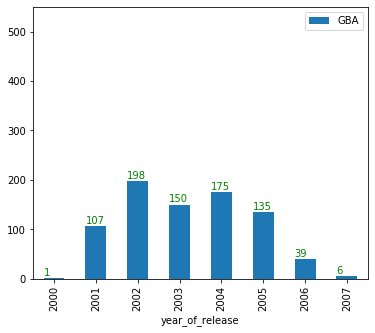

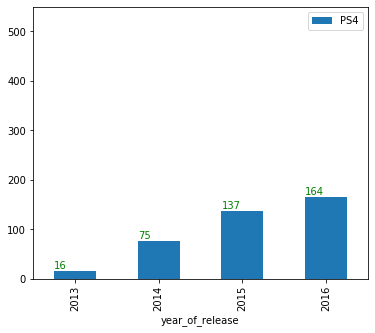

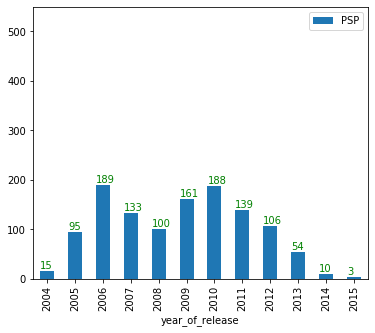

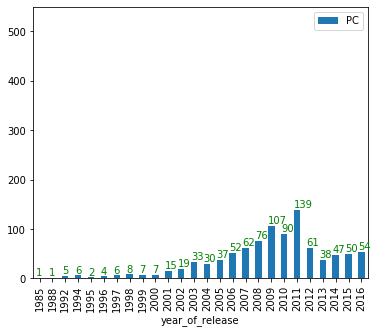

In [28]:
for platform in df_games_platform_sales_top_10.index:
    df_games_platform_years = (
    # choose the platform
    df_games[df_games['platform'] == platform]
    # group by year
    .groupby('year_of_release')
    # rename columns and count number of games
    .agg(games_num=('total_sales', 'count'))
    )
    
    # plot the histogram for "games_num"
    ax = df_games_platform_years.plot(kind='bar', y='games_num', figsize=(6,5), label=platform)
    plt.ylim(0, 550)
    # set labels for columns with "games_num"
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_x(), i.get_height()+5, i.get_height(), fontsize=10, color='green')

*Choose the family platforms with the greatest total sales*

In [29]:
df_games_platform_fam_sales = (
    # group by platform
    df_games.groupby('platform_family')
    # rename columns and calculate total sales for platforms
    .agg(platform_sales=('total_sales', 'sum'))
)

# sort values in descending order
df_games_platform_fam_sales_sorted = df_games_platform_fam_sales.sort_values(by='platform_sales', ascending=False)
df_games_platform_fam_sales_sorted

,platform_sales
platform_family,
playstation,3534.47
nintendo,3496.83
xbox,1388.48
pc,259.52
other,233.99


### Conclusion

- A lot of platform lost their populariry. Espesially PS2, Wii, DS.
- DS, PS2 used to be very popular. But they're not now. Because we have new successors like PS4, WiiU. They're rapidly gaining popularity.
- The PC lost popularity after 2011. It was peak of X360 and PS3. Since 2013 PC's gaining popularity again.
- If we compare 1 family like PS from PS to PS4. We see that the average lifespan of the game console is about 4-5 years. 
- We've confirmed that the most popular family platforms are PS, Nintendo, Xbox, PC. And PS at the top.

### Determine what period you should take data for

We should take data for the last 5 years and to work with latest generations. That'll allow us to build a prognosis for 2017. Other data aren't relevant.

In [30]:
# choose the data since 2011
df_games_good = df_games[df_games['year_of_release'] >= 2011]

### Select several potentially profitable platforms.

'PS4', 'XOne', 'WiiU' are the new platforms. So they can be potentially profitable.

*Group these platforms by year and build a distribution based on data for each year*

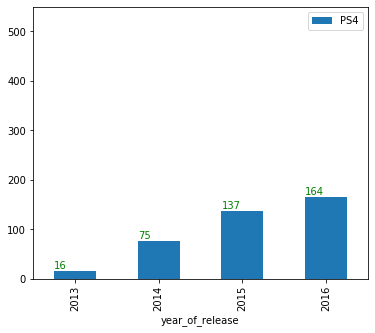

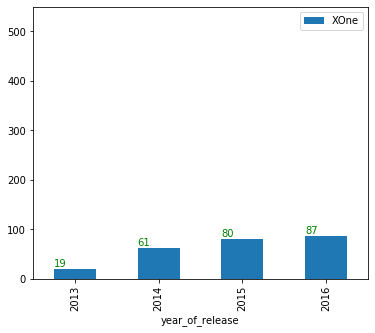

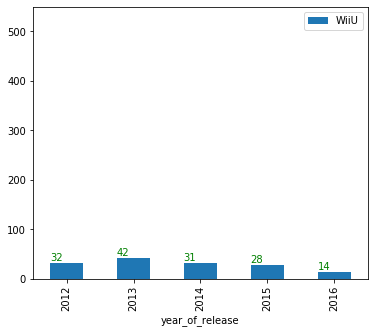

In [31]:
for platform in ('PS4', 'XOne', 'WiiU'):
    df_games_platform_fam_years = (
    # choose the platform
    df_games[df_games['platform'] == platform]
    # group by year
    .groupby('year_of_release')
    # rename columns and count number of games
    .agg(games_num=('total_sales', 'count'))
    )
    
    # plot the histogram for "games_num"
    ax = df_games_platform_fam_years.plot(kind='bar', y='games_num', figsize=(6,5), label=platform)
    plt.ylim(0, 550)
    # set labels for columns with "games_num"
    for i in ax.patches:
        # get_width pulls left or right; get_y pushes up or down
        ax.text(i.get_x(), i.get_height()+5, i.get_height(), fontsize=10, color='green')

Only PS4 and XOne are gaining popularity. So they're potentially profitable platforms.

In [32]:
# df_games_ = df_games[(df_games['platform'] == 'PS4') | (df_games['platform'] == 'XOne') | (df_games['platform'] == 'WiiU')]

### Build a box plot for the global sales of each game, broken down by platform. 

*Choose the data since 2011 and build box plots*

In [33]:
df_games_good_platform_sales = (
# choose the data since 2011
df_games_good
# group by year
.groupby(['platform', 'year_of_release'])
# rename columns and calculate total sales for platforms
.agg(platform_sales=('total_sales', 'sum'))
)

# sort values in descending order
# df_games_good_platform_sales_sorted = df_games_good_platform_sales.sort_values(by='platform_sales', ascending=False)

*Build the box plots for different platforms*

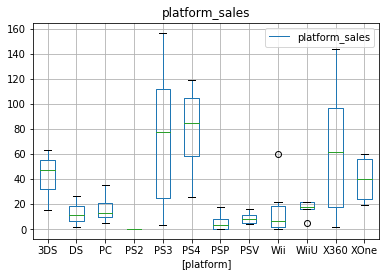

In [34]:
df_games_good_platform_sales.boxplot(by='platform')
plt.suptitle('')
plt.legend(['platform_sales'])
plt.show()

### Conclusion

- We have a lot of sales for PS3, X360, PS4, XOne. 
- PS4 has the greatest median. 
- XOne's not such fast like PS4, but it's perspective as well.

### Build a scatter plot and calculate the correlation between reviews and sales

*Check the connection between 'total_sales', 'critic_score', 'user_score' columns for all selected data "df_games_good"*

In [35]:
# choose the 'total_sales', 'critic_score', 'user_score' columns
df_games_good_pir = df_games_good.loc[:, ['total_sales', 'critic_score', 'user_score']]

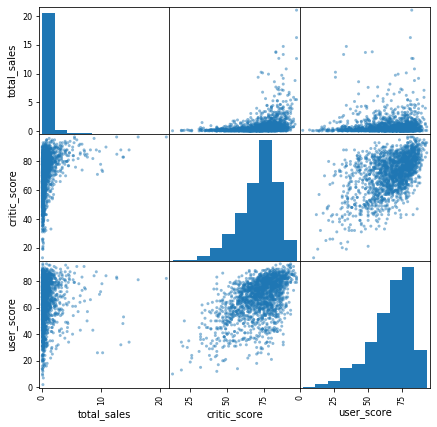

In [36]:
# build scatter plots in pairs 
pd.plotting.scatter_matrix(df_games_good_pir, figsize=(7, 7))
plt.show()

In [37]:
df_games_good_pir.corr() # count Pearson correlation coefficient 

,total_sales,critic_score,user_score
total_sales,1.000000,0.329977,0.031636
critic_score,0.329977,1.000000,0.534853
user_score,0.031636,0.534853,1.000000


*Check the connection between 'total_sales', 'critic_score', 'user_score' columns for the most profitable PS4*

In [38]:
# create dataframe with "ps4"
df_games_good_ps4 = df_games_good[df_games_good['platform'] == 'PS4']

In [39]:
# choose the 'total_sales', 'critic_score', 'user_score' columns
df_games_good_ps4_pir = df_games_good_ps4.loc[:, ['total_sales', 'critic_score', 'user_score']]

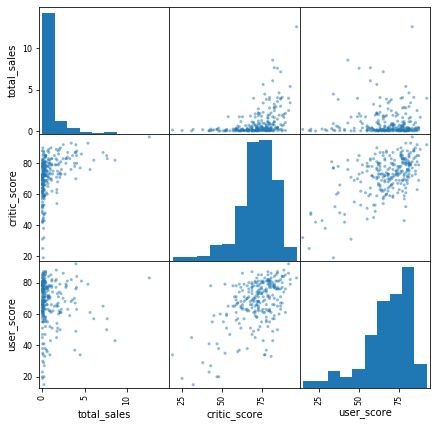

In [40]:
# build scatter plots in pairs 
pd.plotting.scatter_matrix(df_games_good_ps4_pir, figsize=(7, 7))
plt.show()

In [41]:
df_games_good_ps4_pir.corr() # count Pearson correlation coefficient 

,total_sales,critic_score,user_score
total_sales,1.000000,0.406568,-0.031957
critic_score,0.406568,1.000000,0.557654
user_score,-0.031957,0.557654,1.000000


*Check the connection between 'total_sales' and 'critic_score' for "df_games_good" using histograms*

In [42]:
df_games_good_critic_score = (
# choose the data since 2011
df_games_good
# group by year
.groupby('critic_score_cat')
# rename columns and calculate total sales for critic_score
.agg(score_sales=('total_sales', 'sum'))
)

# sort values in ascending order
df_games_good_critic_score_sorted = df_games_good_critic_score.sort_values(by='score_sales')
df_games_good_critic_score_sorted

,score_sales
critic_score_cat,
20,0.31
30,0.66
40,7.55
50,18.52
60,54.42
70,134.98
100,174.21
80,424.78
90,586.32


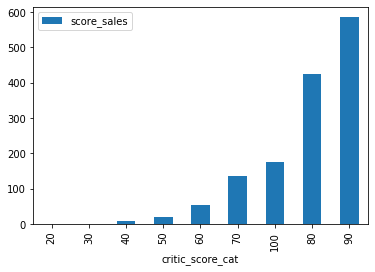

In [43]:
df_games_good_critic_score_sorted.plot(y='score_sales', kind='bar') # plot the bar plot
plt.show()

*Check the connection between 'total_sales' and 'user_score' for "df_games_good" using histograms*

In [44]:
df_games_good_user_score = (
# choose the data since 2011
df_games_good
# group by year
.groupby('user_score_cat')
# rename columns and calculate total sales for user_score
.agg(score_sales=('total_sales', 'sum'))
)

# sort values in ascending order
df_games_good_user_score_sorted = df_games_good_user_score.sort_values(by='score_sales')
df_games_good_user_score_sorted

,score_sales
user_score_cat,
10,0.39
20,3.75
100,22.27
30,34.76
40,75.16
50,129.39
60,186.85
70,312.57
90,345.94


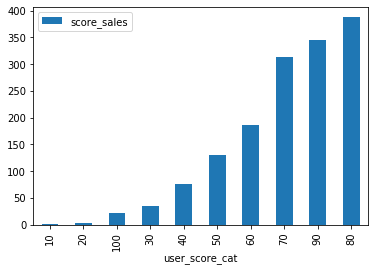

In [45]:
df_games_good_user_score_sorted.plot(y='score_sales', kind='bar') # plot the bar plot
plt.show()

### Conclusion

- We have the medium connection (pir = 0.53) for "critic_score" and "user_score" for all selected data "df_games_good". And there's the weak connection for remain columns.
- The same situation for PS4. There's medium connection (pir = 0.56) for "critic_score" and "user_score".
- When we used the histograms between "total_sales" and "critic_score_cat", "total_sales" and "user_score_cat" we see some connection. When "total_sales" growths "critic_score_cat" and "user_score_cat" growths as well. But we have outlier in "100". Probably it happens because we have a lot of NaN in our columns.

### Compare the sales of the same games on other platforms

In [46]:
# look at the 10 most popular games
df_games_popular = df_games_good['name'].value_counts().head(10)
df_games_popular

LEGO Marvel Super Heroes        9
FIFA 14                         9
FIFA 15                         8
LEGO Jurassic World             8
LEGO The Hobbit                 8
FIFA Soccer 13                  8
The LEGO Movie Videogame        8
Angry Birds Star Wars           8
Terraria                        8
Lego Batman 3: Beyond Gotham    8
Name: name, dtype: int64

In [47]:
# choose the games which appear more than 10 times
# df_games_popular = df_games_popular[df_games_popular > 5]

In [48]:
# create dataframe with the 10 most popular games
df_games_popular = df_games_good.query('name in @df_games_popular.index')

*Group by "platform" and "total_sales"*

In [49]:
df_games_popular_group = (
    # choose the data
    df_games_popular
    # group by pivot_table
    .pivot_table(index='platform', columns='name', values='total_sales')
)

# print 5 rows
df_games_popular_group.head()

name,Angry Birds Star Wars,FIFA 14,FIFA 15,FIFA Soccer 13,LEGO Jurassic World,LEGO Marvel Super Heroes,LEGO The Hobbit,Lego Batman 3: Beyond Gotham,Terraria,The LEGO Movie Videogame
platform,,,,,,,,,,
3DS,0.33,0.23,0.46,0.29,0.62,0.89,0.24,0.45,0.09,0.69
DS,NaN,NaN,NaN,NaN,NaN,0.38,NaN,NaN,NaN,NaN
PC,NaN,0.40,0.29,0.40,0.04,0.17,0.05,0.06,0.14,0.06
PS3,0.29,6.46,4.28,8.17,0.85,1.83,0.46,0.73,0.41,0.93
PS4,0.22,3.01,6.08,NaN,0.90,1.62,0.60,0.92,0.07,0.67


*Plot the histograms of sales top 10 games for different platforms*

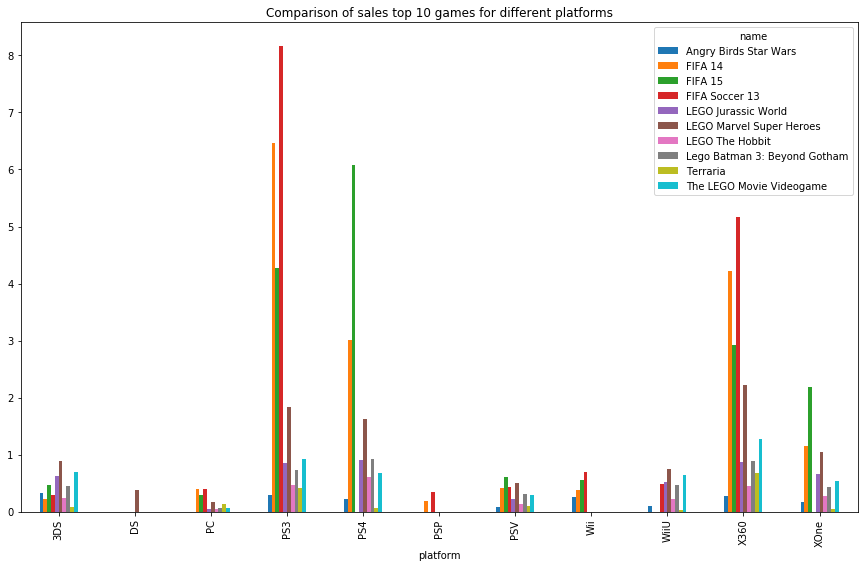

In [50]:
# plot the histograms
df_games_popular_group.plot(kind='bar', figsize=(15, 9), title='Comparison of sales top 10 games for different platforms')
plt.show()

### Conclusion

The largest revenue earner was FIFA Soccer 13 for PS3. FIFA 15 is in second place. But it's in first place for PS4 and XOne. People like football. And LEGO games are popular as well. 

### Take a look at the general distribution of games by genre. What can we say about the most profitable genres? Can you generalize about genres with high and low sales?

In [51]:
# look at the games genres
df_games_genres = df_games_good['genre'].value_counts()
df_games_genres

Action          1269
Role-Playing     465
Adventure        410
Sports           389
Misc             375
Shooter          329
Racing           180
Fighting         159
Simulation       136
Platform         122
Strategy         117
Puzzle            71
Name: genre, dtype: int64

*Group by "genre" and "total_sales"*

In [52]:
df_games_genre_group = (
    # choose the data
    df_games_good
    # group by year
    .groupby('genre')
    # rename columns and calculate total sales for critic_score
    .agg(genre_sales=('total_sales', 'sum'))
)

# sort values in ascending order
df_games_genre_group_sorted = df_games_genre_group.sort_values(by='genre_sales', ascending=False)
df_games_genre_group_sorted

# print 5 rows
df_games_genre_group.head()

,genre_sales
genre,
Action,557.80
Adventure,45.04
Fighting,66.90
Misc,139.42
Platform,88.68


*Plot the histograms of sales different games genres*

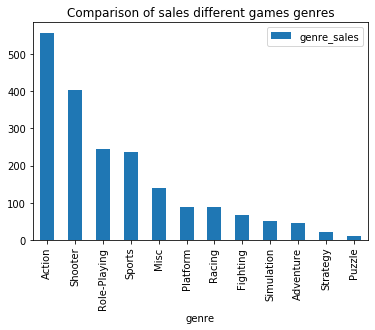

In [53]:
# plot the histograms
df_games_genre_group_sorted.plot(kind='bar', figsize=(6, 4), title='Comparison of sales different games genres')
plt.show()

### Conclusion

We see the most popular genres: action, shooter, role-playing, sports. And we there're very few puzzle sales.

### Step 4. Create a user profile for each region (NA, EU, JP)

### Determine the top five platforms

In [54]:
# create func to show top 5 region sales
def region_sales_5(col):
    df_games_region_sales = (
        # group by platform
        df_games_good.groupby('platform')
        # calculate total sales for platforms
        .agg('sum')[[col]]
    )
    
    # sort values in descending order and show 5 rows
    df_games_region_sales_5 = (
        df_games_region_sales.
        sort_values(by=col, ascending=False).head()
    )
    
    return df_games_region_sales_5

In [55]:
# calculate top 5 for each region
na_sales_5 = region_sales_5('na_sales').reset_index()
eu_sales_5 = region_sales_5('eu_sales').reset_index()
jp_sales_5 = region_sales_5('jp_sales').reset_index()

In [56]:
# show all sales for each region
result_sales = pd.concat([na_sales_5, eu_sales_5, jp_sales_5], axis=1)
result_sales

,platform,na_sales,platform,eu_sales,platform,jp_sales
0,X360,226.80,PS3,163.10,3DS,100.62
1,PS3,168.26,PS4,141.09,PS3,49.39
2,PS4,108.74,X360,117.10,PSP,24.04
3,XOne,93.12,3DS,61.27,PSV,21.84
4,3DS,82.65,PC,56.70,PS4,15.96


### Conclusion

- North America's most profitable market as opposed to Japan.
- We have X360 in North America, PS3 in Europe Union, 3DS (Nintendo) in Japan in first place.
- X360 is produced by Microsoft, USA. So it's logicaly that's popular in this area. PS4 is only in 3 place. But it growths.
- PS4 is in 2nd place in Europe. Probably it has a lot ads in this area.
- PS4 is in 4th place in Japan. But 3DS, PSP, PSV have better positions. Japanese are very busy people, so their mobile platforms are more developed. They play games in the subway.

### Determine the top five genres

*Group by "genre" and region sales*

In [57]:
# create func to show sales for top 5 genres by region
def region_genre_5(col):
    df_games_region_genres = (
        # choose the data
        df_games_good
        # group by year
        .groupby('genre')
        # calculate total sales for genre
        .agg('sum')[[col]]
    )

    # sort values in ascending order
    df_games_region_genres_5 = (
        df_games_region_genres
        .sort_values(by=col, ascending=False).head()
    )
    
    return df_games_region_genres_5

In [58]:
# calculate top 5 for each region
na_sales_genre_5 = region_genre_5('na_sales').reset_index()
eu_sales_genre_5 = region_genre_5('eu_sales').reset_index()
jp_sales_genre_5 = region_genre_5('jp_sales').reset_index()

In [59]:
# show all sales for each region
result_sales_genre = pd.concat([na_sales_genre_5, eu_sales_genre_5, jp_sales_genre_5], axis=1)
result_sales_genre

,genre,na_sales,genre,eu_sales,genre,jp_sales
0,Action,230.92,Action,199.12,Role-Playing,79.87
1,Shooter,194.43,Shooter,148.02,Action,63.62
2,Sports,108.70,Sports,88.48,Misc,17.60
3,Role-Playing,83.78,Role-Playing,62.30,Fighting,12.38
4,Misc,69.69,Racing,40.58,Platform,12.13


### Conclusion

We have similar situation in NA and EU. There're very popular action, shooter, sports. But we have another tendention in Japan. Role-Playing is most popular, action is in 2nd place.

### Determine how ESRB ratings affect sales in individual regions

*Group by "rating" and region sales*

In [60]:
# create func to show sales for rating by region
def region_rating(col):
    df_games_region_rating = (
        # choose the data
        df_games_good
        # group by year
        .groupby('rating')
        # calculate total sales for genre
        .agg('sum')[[col]]
    )

    # sort values in ascending order
    df_games_region_rating_sorted = (
        df_games_region_rating
        .sort_values(by=col, ascending=False)
    )
    
    return df_games_region_rating_sorted

In [61]:
# calculate sales for rating by region
na_sales_rating = region_rating('na_sales').reset_index()
eu_sales_rating = region_rating('eu_sales').reset_index()
jp_sales_rating = region_rating('jp_sales').reset_index()

In [62]:
# show all sales for each region
result_sales_rating = pd.concat([na_sales_rating, eu_sales_rating, jp_sales_rating], axis=1)
result_sales_rating

,rating,na_sales,rating,eu_sales,rating,jp_sales
0,M,308.45,M,250.26,E,36.68
1,E,170.17,E,141.73,T,33.39
2,E10+,117.72,T,83.16,M,26.14
3,T,109.31,E10+,78.00,E10+,11.23
4,EC,0.42,RP,0.03,EC,0.00
5,RP,0.00,EC,0.00,RP,0.00


### Conclusion

We see M in NA and EU in 1st place. Probably we have a lot of games with scenes of violence in this area. But E is the most popular in Japan. Probably there're more teen games than adult.

### Step 5. Test the hypotheses:

*1st hypothesis*:  
- *H0*: Average user ratings of the Xbox One and PC platforms are the same.  
- *H1*: Average user ratings of the Xbox One and PC platforms are different. 

*2nd hypothesis*:  
- *H0*: Average user ratings for the Action and Sports genres are the same.  
- *H1*: Average user ratings for the Action and Sports genres are different.

Threshold p-value = 0.05.

**Look at the 1st hypothesis**

In [63]:
# create 2 dataframes for "XOne" and "PC" platforms
df_games_good_xone = (
    df_games_good[(df_games_good['platform'] == 'XOne') &
    ~(df_games_good['user_score'].isnull())]['user_score']
)

df_games_good_pc = (
    df_games_good[(df_games_good['platform'] == 'PC') &
    ~(df_games_good['user_score'].isnull())]['user_score']
)

In [64]:
# calculate mean "user_score" for "XOne" and "PC" platforms
print(df_games_good_xone.mean().round(2))
print(df_games_good_pc.mean().round(2))

65.21
64.52


In [65]:
alpha = .05 # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        df_games_good_xone, 
        df_games_good_pc)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  0.6267602271422468
We can't reject the null hypothesis


That means average user ratings of the Xbox One and PC platforms are the same. There's a 6.3 % probability of randomly getting a difference that size or larger. This probability is clearly too high to conclude that there's a significant difference between the average amounts spent.

**Look at the 2nd hypothesis**

In [66]:
# create 2 dataframes for "Action" and "Sports" genres
df_games_good_action = (
    df_games_good[(df_games_good['genre'] == 'Action') &
    ~(df_games_good['user_score'].isnull())]['user_score']
)

df_games_good_sports = (
    df_games_good[(df_games_good['genre'] == 'Sports') &
    ~(df_games_good['user_score'].isnull())]['user_score']
)

In [67]:
# calculate mean "user_score" for "Action" and "Sports" genres
print(df_games_good_action.mean().round(2))
print(df_games_good_sports.mean().round(2))

67.76
56.51


In [68]:
alpha = .05 # critical statistical significance level
# if the p-value is less than alpha, we reject the hypothesis

results = st.ttest_ind(
        df_games_good_action, 
        df_games_good_sports)

print('p-value: ', results.pvalue)

if (results.pvalue < alpha):
        print("We reject the null hypothesis")
else:
        print("We can't reject the null hypothesis")

p-value:  5.197455025215018e-24
We reject the null hypothesis


That means the average user ratings for the Action and Sports genres are different. "user_score" for "Action" is more than for "Sports". That confirmed by the previous analysis as well.

### Step 6. Overall conclusion

*The main task:*

We need to identify patterns that determine whether a game succeeds or not.

*Conclusion:*

- The maximum values in the sales were achieved in 2008-2009, then there was a sharp decline. Probably mobile phones began to actively develop, the release of the game for consoles began to take longer due to the complexity of their production.
- A lot of platform lost their populariry. Espesially PS2, Wii, DS.
- DS, PS2 used to be very popular. But they're not now. Because we have new successors like PS4, WiiU, XOne. They're rapidly gaining popularity.
- We've established that the average lifespan of the game console is about 4-5 years. 
- The largest revenue earner was FIFA and LEGO.
- We see the most popular genres: action, shooter, role-playing, sports.
- Playstation is the most popular family platform the whole time by the number of games. PS4 is more perspective than others. XOne's not such fast like PS4, but it's perspective as well.